In [1]:
import polars as pl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

# ETL

In [2]:
df = pl.read_ods('projecoes_2024_tab1_idade_simples.ods')

In [3]:
df.head()

IDADE,SEXO,CÓD.,SIGLA,LOCAL,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,…,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070
i64,str,i64,str,str,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64
0,"""Ambos""",0,"""BR""","""Brasil""",3423475,3347313,3274356,3212295,3163041,3123546,3095244,3013232,2984981,2968870,2918162,2922648,2935674,2922850,2952907,3012970,2948637,2883226,2920425,2885318,2777978,2688491,2597799,2527241,2484344,2431971,2386874,2346516,2310023,2277579,2248982,2222783,…,2154526,2135115,2116131,2096926,2078343,2060737,2043253,2025224,2006805,1988681,1970850,1952779,1934024,1914865,1895555,1875672,1855064,1833975,1812765,1791035,1768271,1744864,1721915,1700174,1678628,1656669,1635347,1615589,1597609,1580751,1564427,1549026,1534801,1521584,1509151,1497237,1485716
1,"""Ambos""",0,"""BR""","""Brasil""",3450022,3406966,3332612,3261091,3200484,3152623,3114345,3087163,3005979,2978318,2958122,2902678,2910301,2925710,2913563,2943154,3002376,2937001,2870232,2910089,2879163,2772134,2680031,2587620,2519770,2477769,2426282,2382021,2342453,2306725,2275013,2246849,…,2173391,2152558,2133170,2114220,2095037,2076482,2058897,2041452,2023485,2005112,1987041,1969262,1951239,1932531,1913420,1894153,1874314,1853749,1832699,1811533,1789840,1767114,1743744,1720831,1699126,1677614,1655686,1634395,1614666,1596716,1579885,1563579,1548205,1534002,1520805,1508394,1496496
2,"""Ambos""",0,"""BR""","""Brasil""",3461038,3444450,3401900,3327924,3256791,3196543,3149015,3111038,3084081,3003124,2972125,2948274,2895233,2904628,2920488,2907915,2936667,2995070,2928703,2863990,2906676,2876276,2767175,2673622,2583366,2516128,2474683,2423745,2380000,2340927,2305679,2274237,…,2195411,2172594,2151751,2132355,2113393,2094206,2075638,2058060,2040638,2022691,2004339,1986288,1968526,1950525,1931835,1912741,1893493,1873673,1853126,1832096,1810943,1789265,1766560,1743207,1720312,1698618,1677119,1655206,1633932,1614217,1596273,1579457,1563166,1547800,1533609,1520415,1508015
3,"""Ambos""",0,"""BR""","""Brasil""",3469109,3458052,3441638,3399284,3325501,3254582,3194489,3147097,3109229,3082358,2998921,2965164,2943133,2891454,2901225,2916787,2903600,2931742,2989393,2924609,2862071,2904924,2873055,2762809,2670309,2580521,2513700,2472629,2422059,2378663,2339922,2304869,…,2219102,2194592,2171767,2150923,2131520,2112549,2093350,2074792,2057237,2039837,2021912,2003581,1985549,1967809,1949823,1931153,1912076,1892846,1873045,1852515,1831500,1810359,1788702,1766017,1742677,1719797,1698118,1676639,1654738,1633474,1613776,1595841,1579039,1562761,1547399,1533216,1520035
4,"""Ambos""",0,"""BR""","""Brasil""",3477903,3466901,3455987,3439662,3397467,3323811,3253080,3193054,3145729,3107906,3079235,2993806,2961429,2940420,2889030,2898606,2913739,2900133,2927764,2986627,2923442,2861079,2902777,2869950,2760203,2668025,2578548,2512000,2471172,2420847,2377678,2339077,…,2244420,2218258,2193747,2170921,2150073,2130661,2111688,2092497,2073963,2056429,2039050,2021146,2002834,1984824,1967099,1949133,1930480,1911423,1892208,1872427,1851909,1830912,1809791,1788148,1765483,1742156,1719290,1697627,1676166,1654275,1633030,1613338,1595416,1578625,1562356,1547006,1532831


In [4]:
for col in df.columns:
    has_nulls = df.select(pl.col(col).has_nulls().any()).item()
    if has_nulls:
        print(f'{col} has null values.')

In [5]:
df = df.filter(
    pl.col('LOCAL') == 'Brasil'
).drop([
    'CÓD.', 'SIGLA', 'LOCAL'
]).rename({
    'IDADE': 'age',
    'SEXO': 'gender'
}).unpivot(
    index=['age', 'gender'],
    on=[str(x) for x in range(2000, 2071)],
    variable_name='year',
    value_name='predicted_population'
).with_columns(
    pl.col('age').cast(pl.Int8),
    pl.col('gender').cast(pl.Categorical),
    pl.col('year').cast(pl.Int16),
    pl.col('predicted_population').cast(pl.Float32)
).with_columns(
    pl.col('gender').replace({
        'Ambos': 'Both',
        'Homens': 'Male',
        'Mulheres': 'Female'
    })
)

In [6]:
df.head()

age,gender,year,predicted_population
i8,cat,i16,f32
0,"""Both""",2000,3.423475e6
1,"""Both""",2000,3.450022e6
2,"""Both""",2000,3.461038e6
3,"""Both""",2000,3.469109e6
4,"""Both""",2000,3.477903e6


# ANALYSIS PER GENDER AND YEAR

In [7]:
df_age_year = df.group_by([
    'gender', 'year'
]).agg(
    pl.col('predicted_population').sum()
).sort(['year', 'gender'], descending=False)

In [8]:
df_age_year.head()

gender,year,predicted_population
cat,i16,f32
"""Both""",2000,1.74695872e8
"""Female""",2000,8.897524e7
"""Male""",2000,8.5720712e7
"""Both""",2001,1.77003712e8
"""Female""",2001,9.0182312e7


In [9]:
years = sorted(df_age_year.select('year').unique().to_series().to_list())

In [10]:
year_max_population_both = df_age_year.filter(
    pl.col('gender') == 'Both'
).sort(
    'predicted_population',
    descending=True
).row(0)[1]

In [11]:
year_max_population_both

2041

In [12]:
year_max_population_male = df_age_year.filter(
    pl.col('gender') == 'Male'
).sort(
    'predicted_population',
    descending=True
).row(0)[1]

In [13]:
year_max_population_male

2041

In [14]:
year_max_population_female = df_age_year.filter(
    pl.col('gender') == 'Female'
).sort(
    'predicted_population',
    descending=True
).row(0)[1]

In [15]:
year_max_population_female

2042

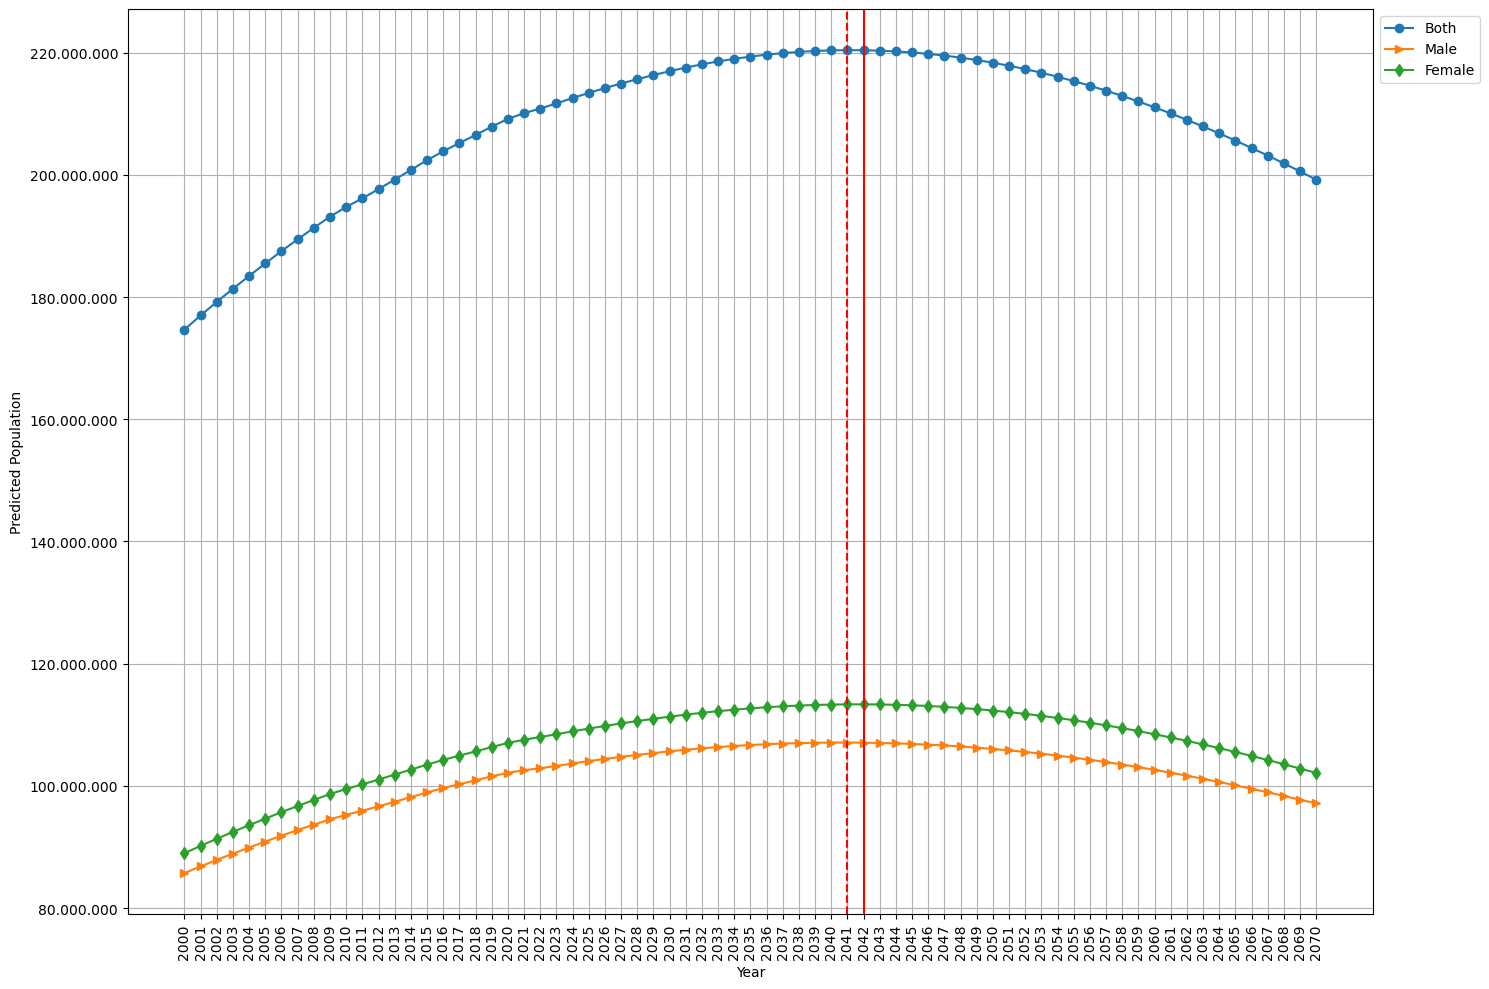

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))

markers = ['o', '>', 'd']

for (gender, group), marker in zip(df_age_year.group_by('gender'), markers):
    plt.plot(
        group.select('year'),
        group.select('predicted_population'),
        label=gender,
        marker=marker
    )


ax.ticklabel_format(style='plain', axis='y')
ax.get_yaxis().set_major_formatter(
    ticker.FuncFormatter(lambda x, p: format(int(x), ',').replace(',', '.'))
)
ax.grid()
ax.tick_params('x', rotation=90)
ax.set_xticks(years)
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_ylabel('Predicted Population')
ax.set_xlabel('Year')
ax.axvline(year_max_population_both, linestyle='--', color='red')
ax.axvline(year_max_population_female, linestyle='-', color='red')

plt.tight_layout()
fig.savefig('predict_population_gender_year.png', dpi=300, bbox_inches='tight')
plt.show()